# 🧠 Brain Tumor MRI Image Classification

# 1. Install & Import Libraries

In [ ]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix


# 2. Mount Google Drive

In [ ]:

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3. Set Data Paths

In [ ]:
data_path = "/content/drive/MyDrive/Tumour"
train_dir = os.path.join(data_path, "train")
val_dir = os.path.join(data_path, "valid")
test_dir = os.path.join(data_path, "test")


# 4. Visualize Sample Images

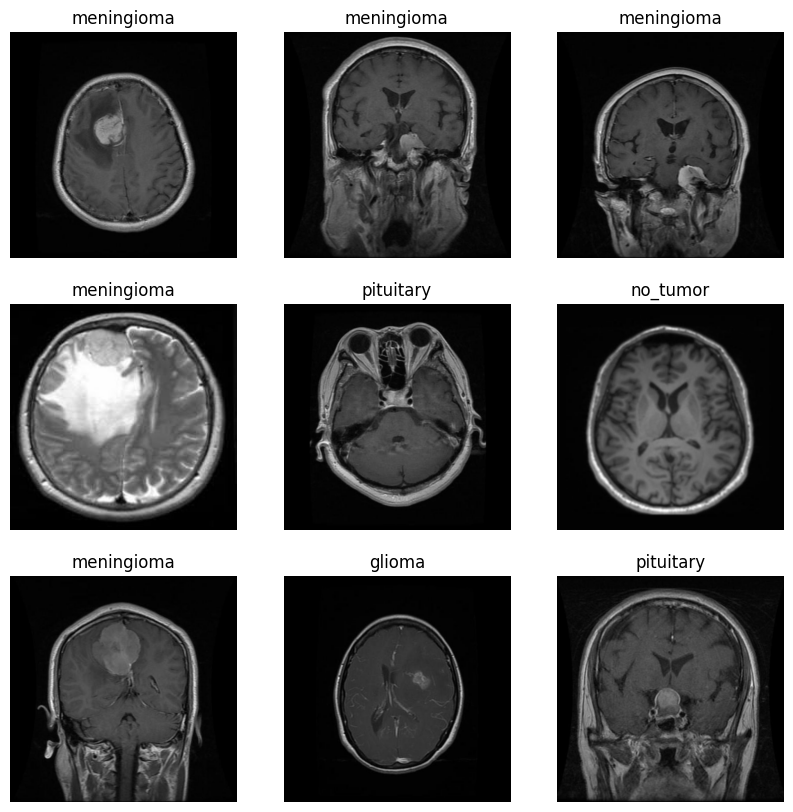

In [ ]:
import matplotlib.image as mpimg
import random
import os

def plot_images_from_directory(directory, n_images=9):
    plt.figure(figsize=(10,10))
    # Filter out non-directory entries
    all_classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for i in range(n_images):
        cls = random.choice(all_classes)
        img_path = os.path.join(directory, cls, random.choice(os.listdir(os.path.join(directory, cls))))
        img = mpimg.imread(img_path)
        plt.subplot(3,3,i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis('off')
    plt.show()

plot_images_from_directory(train_dir)

# 5. Data Generators & Augmentation

In [ ]:

img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1,
                                   height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width),
                                              batch_size=batch_size, class_mode='categorical')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(img_height, img_width),
                                          batch_size=batch_size, class_mode='categorical')
test_gen = val_datagen.flow_from_directory(test_dir, target_size=(img_height, img_width),
                                           batch_size=batch_size, class_mode='categorical', shuffle=False)


Found 1695 images belonging to 4 classes.
Found 502 images belonging to 4 classes.
Found 246 images belonging to 4 classes.


# 6. Build Custom CNN

In [ ]:

custom_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_height,img_width,3)),
    MaxPooling2D(2,2), BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'), MaxPooling2D(2,2), BatchNormalization(),
    Conv2D(128, (3,3), activation='relu'), MaxPooling2D(2,2), BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'), Dropout(0.5),
    Dense(train_gen.num_classes, activation='softmax')
])
custom_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 111, 111, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,372 (42.61 MB)

 Trainable params: 11,169,924 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

# 7. Train Custom CNN

In [ ]:

callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
             ModelCheckpoint("/content/drive/MyDrive/custom_cnn_final.h5", save_best_only=True)]

history_cnn = custom_cnn.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4358 - loss: 7.4087

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 463s 9s/step - accuracy: 0.4361 - loss: 7.3459 - val_accuracy: 0.2470 - val_loss: 7.2473
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.4108 - loss: 1.5979 - val_accuracy: 0.1394 - val_loss: 8.5250
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - accuracy: 0.4673 - loss: 1.6049 - val_accuracy: 0.2410 - val_loss: 7.5159
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5029 - loss: 1.2509

53/53 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.5031 - loss: 1.2524 - val_accuracy: 0.3008 - val_loss: 3.5302
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5294 - loss: 1.2702

53/53 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.5292 - loss: 1.2699 - val_accuracy: 0.3147 - val_loss: 3.3691
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5058 - loss: 1.1148

53/53 ━━━━━━━━━━━━━━━━━━━━ 255s 5s/step - accuracy: 0.5058 - loss: 1.1148 - val_accuracy: 0.2769 - val_loss: 3.0182
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5209 - loss: 1.1432

53/53 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.5212 - loss: 1.1437 - val_accuracy: 0.5179 - val_loss: 1.0479
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5307 - loss: 1.1950

53/53 ━━━━━━━━━━━━━━━━━━━━ 257s 5s/step - accuracy: 0.5308 - loss: 1.1944 - val_accuracy: 0.5598 - val_loss: 1.0334
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5454 - loss: 1.1568

53/53 ━━━━━━━━━━━━━━━━━━━━ 254s 5s/step - accuracy: 0.5451 - loss: 1.1571 - val_accuracy: 0.5478 - val_loss: 0.9397
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5335 - loss: 1.0853

53/53 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.5339 - loss: 1.0854 - val_accuracy: 0.5637 - val_loss: 0.9337
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5846 - loss: 1.0763

53/53 ━━━━━━━━━━━━━━━━━━━━ 261s 5s/step - accuracy: 0.5844 - loss: 1.0764 - val_accuracy: 0.5837 - val_loss: 0.9018
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - accuracy: 0.5589 - loss: 1.1015 - val_accuracy: 0.6414 - val_loss: 0.9159
Epoch 13/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5676 - loss: 1.0613

53/53 ━━━━━━━━━━━━━━━━━━━━ 243s 5s/step - accuracy: 0.5680 - loss: 1.0614 - val_accuracy: 0.6833 - val_loss: 0.8837
Epoch 14/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.5704 - loss: 1.0399 - val_accuracy: 0.4283 - val_loss: 3.1863
Epoch 15/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5818 - loss: 1.0986

53/53 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.5820 - loss: 1.0976 - val_accuracy: 0.6773 - val_loss: 0.7511
Epoch 16/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 273s 5s/step - accuracy: 0.5735 - loss: 1.0190 - val_accuracy: 0.6693 - val_loss: 0.8519
Epoch 17/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.6009 - loss: 0.9972 - val_accuracy: 0.5936 - val_loss: 1.1835
Epoch 18/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.5686 - loss: 0.9929 - val_accuracy: 0.5737 - val_loss: 1.2920
Epoch 19/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 246s 5s/step - accuracy: 0.5987 - loss: 1.0313 - val_accuracy: 0.4343 - val_loss: 2.7268
Epoch 20/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.5718 - loss: 0.9873 - val_accuracy: 0.5618 - val_loss: 1.5832


# 8. Plot Training History

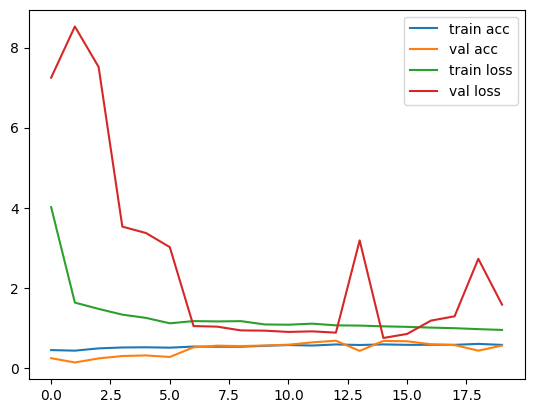

In [ ]:

plt.plot(history_cnn.history['accuracy'], label='train acc')
plt.plot(history_cnn.history['val_accuracy'], label='val acc')
plt.plot(history_cnn.history['loss'], label='train loss')
plt.plot(history_cnn.history['val_loss'], label='val loss')
plt.legend()
plt.show()


# 9. Build Transfer Learning (MobileNetV2)

In [ ]:

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height,img_width,3))
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

transfer_model = Model(inputs=base_model.input, outputs=output)
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# 10. Train Transfer Learning Model

In [ ]:

callbacks[1] = ModelCheckpoint("/content/drive/MyDrive/mobilenetv2_final.h5", save_best_only=True)
history_tl = transfer_model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=callbacks)


Epoch 1/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5355 - loss: 1.1658

53/53 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5382 - loss: 1.1595 - val_accuracy: 0.7908 - val_loss: 0.5263
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8078 - loss: 0.5046

53/53 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.8079 - loss: 0.5045 - val_accuracy: 0.8187 - val_loss: 0.4883
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8533 - loss: 0.3942

53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8533 - loss: 0.3943 - val_accuracy: 0.8426 - val_loss: 0.4339
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.8555 - loss: 0.3994 - val_accuracy: 0.7928 - val_loss: 0.5677
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.8755 - loss: 0.3434 - val_accuracy: 0.8446 - val_loss: 0.4344
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8817 - loss: 0.3316 - val_accuracy: 0.8187 - val_loss: 0.5304
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8888 - loss: 0.3106

53/53 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.8888 - loss: 0.3104 - val_accuracy: 0.8725 - val_loss: 0.4222
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - accuracy: 0.9078 - loss: 0.2661 - val_accuracy: 0.8586 - val_loss: 0.4487
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9136 - loss: 0.2388 - val_accuracy: 0.8267 - val_loss: 0.4764
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9083 - loss: 0.2508 - val_accuracy: 0.8267 - val_loss: 0.5354
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9011 - loss: 0.2760 - val_accuracy: 0.8386 - val_loss: 0.5167
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9101 - loss: 0.2379 - val_accuracy: 0.8506 - val_loss: 0.4686


# 11. Evaluate on Test Set

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 63s 9s/step
Classification Report for Custom CNN
              precision    recall  f1-score   support

      glioma       0.66      0.97      0.79        80
  meningioma       0.39      0.11      0.17        63
    no_tumor       0.82      0.55      0.66        49
   pituitary       0.68      0.96      0.79        54

    accuracy                           0.67       246
   macro avg       0.64      0.65      0.60       246
weighted avg       0.63      0.67      0.61       246



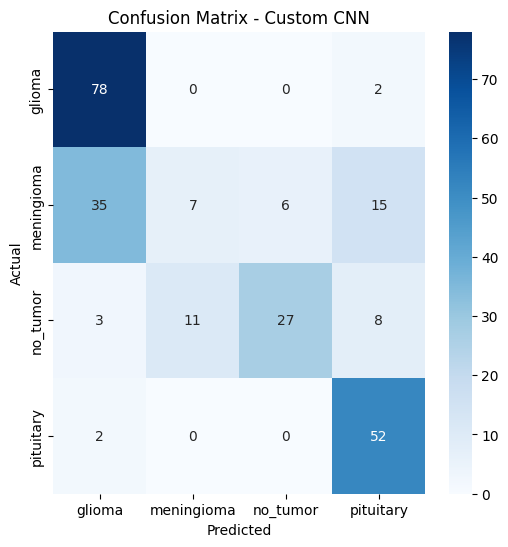

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
Classification Report for MobileNetV2
              precision    recall  f1-score   support

      glioma       0.86      0.94      0.90        80
  meningioma       0.85      0.54      0.66        63
    no_tumor       0.91      0.82      0.86        49
   pituitary       0.72      1.00      0.84        54

    accuracy                           0.83       246
   macro avg       0.84      0.82      0.81       246
weighted avg       0.84      0.83      0.82       246



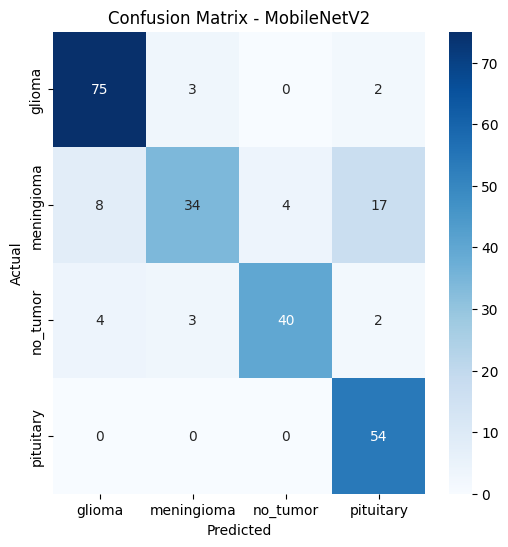

In [ ]:

def evaluate_model(model, name):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_true = test_gen.classes
    print(f"Classification Report for {name}")
    print(classification_report(y_true, y_pred, target_names=list(test_gen.class_indices.keys())))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=list(test_gen.class_indices.keys()),
                yticklabels=list(test_gen.class_indices.keys()))
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(custom_cnn, "Custom CNN")
evaluate_model(transfer_model, "MobileNetV2")


# 12. Save Final Models

In [ ]:

custom_cnn.save("/content/drive/MyDrive/custom_cnn_final2.h5")
transfer_model.save("/content/drive/MyDrive/mobilenetv2_final2.h5")
